In [18]:
import numpy as np
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

### **Utilities and ForwardModel (Helper functions and the class of the model)**

###### **Utilities file copied here!**

In [19]:
dtype = torch.float
device = torch.device("cpu")

def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)

    # Reshape on a column tensor and return
    return x.view(samples, 1)

def trapezoidal_integration_1d(y, x):
    """Compute the integral of y = f(x) over the range of x using the trapezoidal rule."""

    # Compute delta x assuming it's constant over the range of x
    dx = x[1] - x[0]

    # Compute the integral with the trapezoidal rule
    result = torch.sum(y)
    result = result - (y[0] + y[-1]) / 2

    return result * dx

def get_derivative(y, x, n):  # Explain
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)


def build_model(input_dimension, hidden_dimension, output_dimension):
    """Build a neural network of given dimensions."""

    modules=[]
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh()) # Activation function
    for i in range(len(hidden_dimension)-1):
        print('check',len(hidden_dimension))
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())
    
    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))
    
    model = torch.nn.Sequential(*modules) # final whole model defn

    return model

def plot_displacements_bar(x, u, u_analytic=None):
    """Plot displacements."""

    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Displacements")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")

    # Plot data
    if u_analytic != None:
        ax.plot(x.detach().numpy(), u_analytic(x.detach().numpy()),color='r', linewidth=2, label="u_analytic")
    ax.plot(x.detach().numpy(), u.detach().numpy(),color='k',linestyle=':',linewidth=5, label="u_pred")

    ax.legend()
    plt.show()
    fig.tight_layout()
    
def plot_stiffness_bar(x, EA, EA_analytic=None):
    """Plot stiffness."""
    
    # Set up plot
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Stiffness")
    ax.set_xlabel("x")
    ax.set_ylabel("EA")

    # Plot data
#     ax.plot(x.detach().numpy(), EA.detach().numpy(),color='r', label="EA_pred")
    if EA_analytic != None:
        ax.plot(x.detach().numpy(), EA_analytic(x.detach().numpy()), label="EA_analytic")
    ax.plot(x.detach().numpy(), EA.detach().numpy(),color='k',linestyle=':',linewidth=5, label="EA_pred")
    ax.legend()
    plt.show()
    fig.tight_layout()


###### **Class ForwardModel**

In [20]:
class ForwardModel:
    """A class used for the definition of Physics Informed Models for one dimensional bars."""

    def __init__(self, kostfunksion):
        """Construct a PhysicsInformedBar model"""

        self.L = 1
        self.costFunction = kostfunksion
        self.x = generate_grid_1d(self.L)
        self.model = build_model(1,[40,40],1)
        self.differential_equation_loss_history = None
        self.boundary_condition_loss_history = None
        self.total_loss_history = None
        self.optimizer = None

    def get_displacements(self, x):
        """Get displacements."""

        u = self.model(x)   # predict

        return u

    def closure(self):
        """Calculation of training error and gradient"""
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, optimizer='Adam', **kwargs):
        """Train the model."""

        # Set optimizer
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
        
        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        # Initialize history arrays
        self.differential_equation_loss_history = np.zeros(epochs)
        self.boundary_condition_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)
        # Training loop
        for i in range(epochs):
            # Predict displacements
            u_pred = self.get_displacements(self.x)

            # Cost function calculation
            differential_equation_loss, boundary_condition_loss = self.costFunction(self.x, u_pred)

            # Total loss
            total_loss = differential_equation_loss + boundary_condition_loss

            # Add energy values to history
            self.differential_equation_loss_history[i] += differential_equation_loss
            self.boundary_condition_loss_history[i] += boundary_condition_loss
            self.total_loss_history[i] += total_loss

            # Print training state
            self.print_training_state(i, epochs)

            # Update parameters (Neural network train)
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every=100):
        """Print the loss values of the current epoch in a training loop."""

        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            # Prepare string
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"

            # Format string and print
            print(string.format(epoch, epochs - 1, self.differential_equation_loss_history[epoch],
                                self.boundary_condition_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        """Plot the training history."""

        # Set up plot
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Cost function history")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Cost function C")
        plt.yscale(yscale)

        # Plot data
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total cost")
        ax.plot(self.differential_equation_loss_history, color='silver', linestyle='--', linewidth=2, label="Differential equation loss")
        ax.plot(self.boundary_condition_loss_history, color='r', linestyle='-.', linewidth=2, label="Boundary condition loss")
        

        ax.legend()
        fig.tight_layout()
        plt.show() 



### **Problem - 1**

In [21]:
def costFunction_problem2(x, u_pred):
    
    # Differential equation loss (f)
    differential_equation_loss = 2*(1+x)*get_derivative(u_pred, x, 1) + 10
    differential_equation_loss = torch.sum(differential_equation_loss ** 2).view(1)

    # Boundary condition loss initialization
    boundary_condition_loss = 0

    # Sum over dirichlet boundary condition losses
    boundary_condition_loss += (u_pred[0]) ** 2

    return differential_equation_loss, boundary_condition_loss

In [22]:
u_analytic = lambda x: -5*np.log(1+x)

epochs = 400
learningRate = 0.01

pinnModel_problem2 = ForwardModel(costFunction_problem2)
pinnModel_problem2.train(epochs, optimizer='LBFGS', lr=learningRate)

check 2
Epoch: 0/399		Differential equation loss = 2117.900146		Boundary condition loss = 0.036379		Total loss = 2117.936523
Epoch: 100/399		Differential equation loss = 0.000019		Boundary condition loss = 0.000000		Total loss = 0.000019
Epoch: 200/399		Differential equation loss = 0.000019		Boundary condition loss = 0.000000		Total loss = 0.000019
Epoch: 300/399		Differential equation loss = 0.000019		Boundary condition loss = 0.000000		Total loss = 0.000019
Epoch: 399/399		Differential equation loss = 0.000019		Boundary condition loss = 0.000000		Total loss = 0.000019


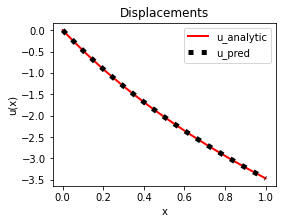

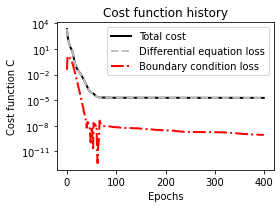

In [23]:
samples = 100
x_test = generate_grid_1d(1, samples)
u_test = pinnModel_problem2.get_displacements(x_test)

plot_displacements_bar(x_test, u_test, u_analytic)
pinnModel_problem2.plot_training_history()

### **Problem - 2** :
   ##### Did the problem in two ways. With cost function including the differential equation loss as
     (i) sum of squares of expressions.    (with 500 epochs)
    (ii) sum of 4th power of expressions.  (with 20 epochs)

In [24]:
# differential_equation_loss is sum of squares of expressions.
def costFunction_problem3_sqrd_diff_loss(x, u_pred):
    
    a = get_derivative(u_pred, x, 1)
        
    # Differential equation loss (f)
    differential_equation_loss = get_derivative(a, x, 3) + 1
    differential_equation_loss = torch.sum(differential_equation_loss ** 2).view(1)  # check this for difference

    # Boundary condition loss initialization
    boundary_condition_loss = 0

    # Sum over dirichlet boundary condition losses
    boundary_condition_loss += (u_pred[0]) ** 2
    boundary_condition_loss += (u_pred[-1]) ** 2
    boundary_condition_loss += a[0] ** 2
    boundary_condition_loss += a[-1] ** 2

    return differential_equation_loss, boundary_condition_loss

# differential_equation_loss is sum of 4th power of expressions.
def costFunction_problem3_quad_diff_loss(x, u_pred):
    
    a = get_derivative(u_pred, x, 1)
        
    # Differential equation loss (f)
    differential_equation_loss = get_derivative(a, x, 3) + 1
    differential_equation_loss = torch.sum(differential_equation_loss ** 4).view(1)  # check this for difference

    # Boundary condition loss initialization
    boundary_condition_loss = 0

    # Sum over dirichlet boundary condition losses
    boundary_condition_loss += (u_pred[0]) ** 2
    boundary_condition_loss += (u_pred[-1]) ** 2
    boundary_condition_loss += a[0] ** 2
    boundary_condition_loss += a[-1] ** 2

    return differential_equation_loss, boundary_condition_loss

###### **Method - 1** (With differential_equation_loss as the sum of squared differences)

In [25]:
u_analytic = lambda x: -x**4/24 +x**3/12 - x**2/24
epochs = 500
learningRate = 0.01

pinnModel_problem3_try1 = ForwardModel(costFunction_problem3_sqrd_diff_loss)
pinnModel_problem3_try1.train(epochs, optimizer='LBFGS', lr=learningRate)

check 2
Epoch: 0/499		Differential equation loss = 21.746298		Boundary condition loss = 0.161133		Total loss = 21.907431
Epoch: 100/499		Differential equation loss = 0.000056		Boundary condition loss = 0.000014		Total loss = 0.000070
Epoch: 200/499		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 300/499		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 400/499		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 499/499		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001


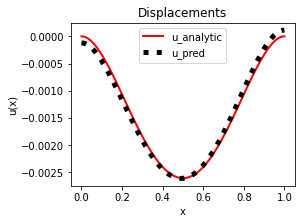

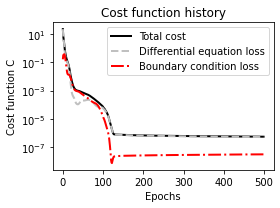

In [26]:
samples = 100
x_test = generate_grid_1d(1, samples)
u_test = pinnModel_problem3_try1.get_displacements(x_test)

plot_displacements_bar(x_test, u_test, u_analytic)
pinnModel_problem3_try1.plot_training_history()

###### **Method - 2** (With differential_equation_loss as the sum of 4th power of differences)

In [27]:
epochs = 20
learningRate = 0.2

pinnModel_problem3_try2 = ForwardModel(costFunction_problem3_quad_diff_loss)
pinnModel_problem3_try2.train(epochs, optimizer='LBFGS', lr=learningRate)

check 2
Epoch: 0/19		Differential equation loss = 4.477386		Boundary condition loss = 0.155409		Total loss = 4.632795
Epoch: 19/19		Differential equation loss = 0.000000		Boundary condition loss = 0.000000		Total loss = 0.000000


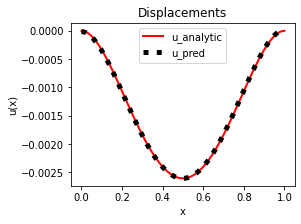

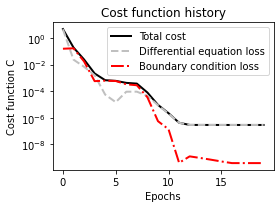

In [28]:
samples = 100
x_test = generate_grid_1d(1, samples)
u_test = pinnModel_problem3_try2.get_displacements(x_test)

plot_displacements_bar(x_test, u_test, u_analytic)
pinnModel_problem3_try2.plot_training_history()

###### **Comparing these two models**

In [29]:
sqrd_model = ForwardModel(costFunction_problem3_sqrd_diff_loss)
sqrd_model.train(400, optimizer='LBFGS', lr=0.01)

quad_model = ForwardModel(costFunction_problem3_quad_diff_loss)
quad_model.train(20, optimizer='LBFGS', lr=0.2)

x_test = generate_grid_1d(1, samples)

u_test = sqrd_model.get_displacements(x_test)
u_test1 = quad_model.get_displacements(x_test)

check 2
Epoch: 0/399		Differential equation loss = 25.492346		Boundary condition loss = 0.072436		Total loss = 25.564781
Epoch: 100/399		Differential equation loss = 0.000126		Boundary condition loss = 0.000578		Total loss = 0.000704
Epoch: 200/399		Differential equation loss = 0.000021		Boundary condition loss = 0.000000		Total loss = 0.000021
Epoch: 300/399		Differential equation loss = 0.000021		Boundary condition loss = 0.000000		Total loss = 0.000021
Epoch: 399/399		Differential equation loss = 0.000020		Boundary condition loss = 0.000000		Total loss = 0.000021
check 2
Epoch: 0/19		Differential equation loss = 29.682034		Boundary condition loss = 0.003005		Total loss = 29.685040
Epoch: 19/19		Differential equation loss = 0.000000		Boundary condition loss = 0.000000		Total loss = 0.000000


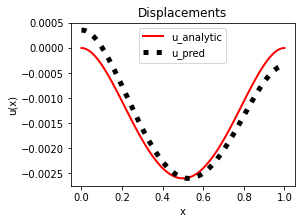

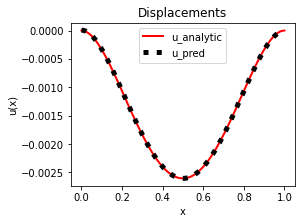

In [30]:
plot_displacements_bar(x_test, u_test, u_analytic)
plot_displacements_bar(x_test, u_test1, u_analytic)

The 4th powered differential loss model gives very accurate result everytime we run, where as the other model gives low to good accuracy at different times we run.

Here, the first graph indicates the model including normal calculation of differential equation loss as **squares of the expressions** with **400 epochs** and **0.01 learning rate**.<br>
Whereas, the second graph indicates the model including calculation of differential equation loss as **4th power of the expressions** with just **20 epochs** and **0.2 learning rate**.

This tells that the second one might be a good model, and also says that the optimised way of considering total loss as a function of differential equation loss and boundary loss will be different for different equations and might also depend on number of sample points in claculating diff_eqn_loss. Considering the sum of the two squared losses mostly feels like a general way to use, as it works almost everytime with sufficient accuracy, provided it has correct number of epochs and learning rate.